# Setup

In [3]:
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [4]:
# Prepare train and test data
train_dataset = MNIST(download=True, root='data', train=True, transform=ToTensor())
train_data = DataLoader(train_dataset, batch_size=64, shuffle=False)

test_dataset = MNIST(download=True, root='data', train=False, transform=ToTensor())
test_data = DataLoader(test_dataset, batch_size=32, shuffle=False)

/opt/homebrew/Caskroom/miniforge/base/envs/bachelor-project/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1635217266490/work/torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
# Make results reproducible
random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

In [6]:
# Membrane time constant
T_RC = 0.02
T_REF = 4e-3
V_TH = 1.0

In [7]:
def sigmoid(x, deriv=False):
  out = F.sigmoid(x)
  if deriv:
    return out * (1 - out)
  return out

def leaky_relu(x, deriv=False):
  factor = (x > 0) + 0.1
  if deriv:
    return factor
  return factor * x

def rate(x, p=torch.relu, t_rc = T_RC, t_ref = T_REF, V_th = V_TH, epsilon=1e-12, deriv=False):
  b = (p(x - V_th) + epsilon)
  l = 1 + V_th / b
  r = torch.reciprocal(t_ref + t_rc * torch.log(l))
  if deriv:
    return (r ** 2) * t_rc / l * V_th / (b ** 2) * p(x - V_th, deriv=True)
  return r

def soft_plus(x, beta=20, threshold=20, deriv=False):
  if deriv:
    out = 1 / beta * 1 / (1 + torch.exp(beta * x)) * beta * torch.exp(beta * x)
    out[beta * x > threshold] = 1
    return out
  return torch.nn.functional.softplus(x, beta=beta, threshold=threshold)

def soft_rate(x, t_rc = T_RC, t_ref = T_REF, V_th = V_TH, deriv=False):
  if deriv:
    return rate(x, p=soft_plus, t_rc=t_rc, t_ref=t_ref, V_th=V_th, deriv=True)
  return rate(x, p=soft_plus, t_rc=t_rc, t_ref=t_ref, V_th=V_th)

def scaled_soft_rate(x, t_rc = T_RC, t_ref = T_REF, V_th = V_TH, scale = 0.05, deriv=False):
  if deriv:
    return soft_rate(x, t_rc=t_rc, t_ref=t_ref, V_th=V_th, deriv=True) * scale
  return soft_rate(x, t_rc=t_rc, t_ref=t_ref, V_th=V_th) * scale

def softmax(x, deriv=False):
  if deriv:
    # This is little unusual, but is required to calculate correct the correct partial derivate if e = x - u
    return torch.ones_like(x) 
  return x.exp() / x.exp().sum(dim=1, keepdim=True)

def onehot(x, n_classes):
  return torch.eye(n_classes)[x]

def get_weights_and_biases(in_features, out_features):
  W = torch.randn((out_features, in_features)) * 2/math.sqrt(in_features)
  b = torch.zeros(out_features)

  return W, b

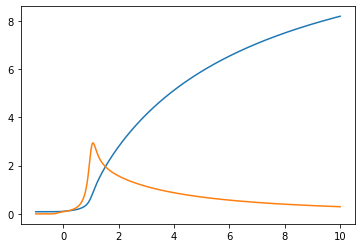

In [8]:
x = torch.linspace(-1, 10, 1000)
r = scaled_soft_rate(x)
dr = scaled_soft_rate(x, deriv=True)

plt.plot(x, r)
plt.plot(x, dr)

plt.show()

# Back-propagation

In [251]:
# Define out layer sizes
in_features = 784
hidden1_features = 300
hidden2_features = 300
out_features = 10

# Define weights and biases
W1, b1 = get_weights_and_biases(in_features, hidden1_features)
W2, b2 = get_weights_and_biases(hidden1_features, hidden2_features)
W3, b3 = get_weights_and_biases(hidden2_features, out_features)

activation1 = leaky_relu
activation2 = leaky_relu
activation3 = softmax

In [252]:
# Baseline backprop model
class MLP(nn.Module):
  def __init__(self, in_features, hidden1_features, hidden2_features, out_features):
    super().__init__()
    self.l1 = nn.Linear(in_features, hidden1_features)
    self.l2 = nn.Linear(hidden1_features, hidden2_features)
    self.l3 = nn.Linear(hidden2_features, out_features)

    # Start with exactly the same weights.
    with torch.no_grad():
      self.l1.weight.copy_(W1)
      self.l1.bias.copy_(b1)
      self.l2.weight.copy_(W2)
      self.l2.bias.copy_(b2)
      self.l3.weight.copy_(W3)
      self.l3.bias.copy_(b3)

  def forward(self, x):
    x = activation1(self.l1(x))
    x = activation2(self.l2(x))
    x = self.l3(x)
    return x


model = MLP(in_features, hidden1_features, hidden2_features, out_features)

In [17]:
loss_history = []
accuracy_history = []
step = 0
accuracy = 0
loss = None

In [18]:
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

NameError: name 'model' is not defined

In [ ]:
for epoch in range(1):
  print(f"Epoch {epoch+1}")
  tqdm_train_data = tqdm(train_data)
  for images, labels in tqdm_train_data:
    step += 1

    optimizer.zero_grad()
    x0 = images.flatten(start_dim=1)

    pred = model(x0)
    loss = criterion(pred, labels)
    loss.backward()
    
    loss_history.append((step, loss.item()))

    tqdm_train_data.set_description(f"Training - Loss: {loss.item():.4f} - Accuracy: {accuracy*100:.2f}%")

    optimizer.step()

    if step % 100 == 0: 
      model.eval()
      tqdm_train_data.set_description(f"Testing - Loss: {loss.item():.4f} - Accuracy: {accuracy*100:.2f}%")
      tested = 0
      correct = 0
      for images, labels in test_data:
        x0 = images.flatten(start_dim=1)
        x3_pred = model(x0)
        pred_labels = x3_pred.argmax(dim=1)

        tested += len(pred_labels)
        correct += (pred_labels == labels).sum()
      accuracy = correct / tested
      

      accuracy_history.append((step, accuracy))
      model.train()
    

Epoch 1


  0%|          | 0/938 [00:00<?, ?it/s]

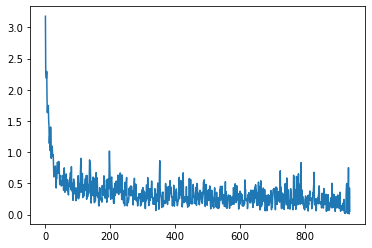

In [ ]:
plt.plot(*zip(*loss_history))
plt.show()

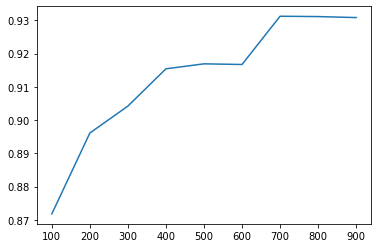

In [ ]:
plt.plot(*zip(*accuracy_history))
plt.show()

In [ ]:
# Save loss and accuracy history
torch.save(loss_history, "../results/backprop-loss_history.pt")
torch.save(accuracy_history, "../results/backprop-accuracy_history.pt")

In [ ]:
torch.save(model.state_dict(), "../results/backprop/model.py")

In [ ]:
tested = 0
correct = 0
for images, labels in test_data:
  x0 = images.flatten(start_dim=1)
  x3_pred = model(x0)
  pred_labels = x3_pred.argmax(dim=1)

  tested += len(pred_labels)
  correct += (pred_labels == labels).sum()

accuracy = correct / tested
print(f"Accuracy: {accuracy * 100}%")

KeyboardInterrupt: 

In [ ]:
logits = torch.tensor([[2.0, 5.0, 2.0, 2.0, 2.0], [2.0, 5.0, 2.0, 2.0, 2.0]])
pred = softmax(logits)
labels = torch.tensor([1, 2])

print(nn.CrossEntropyLoss()(logits, labels))
print(-(torch.log(pred) * torch.stack([onehot(label, pred.shape[1]) for label in labels])).sum(dim=1).mean())

tensor(1.6816)
tensor(1.6816)


# Inference Learning

In [ ]:
# Define out layer sizes
in_features = 784
hidden1_features = 32
hidden2_features = 32
out_features = 10

# Define weights and biases
W1, b1 = get_weights_and_biases(in_features, hidden1_features)
W2, b2 = get_weights_and_biases(hidden1_features, hidden2_features)
W3, b3 = get_weights_and_biases(hidden2_features, out_features)

activation1 = leaky_relu
activation2 = leaky_relu
activation3 = softmax

NameError: name 'get_weights_and_biases' is not defined

In [ ]:
loss_history = []
accuracy_history = []
accuracy = 0
loss = 0
step = 0

In [ ]:
# Setup hyperparameters
ir = 4e-1 # Inference rate
lr = 1e-1 # Learning rate

# Should we just test the inference part
test = True

Epoch 1


  0%|          | 0/938 [00:00<?, ?it/s]

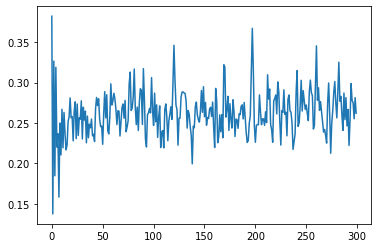

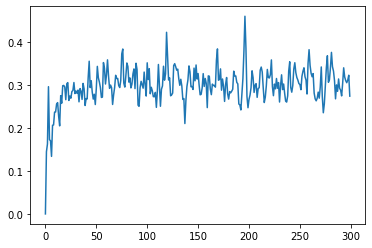

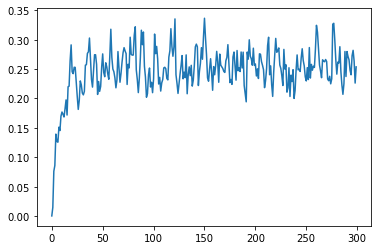

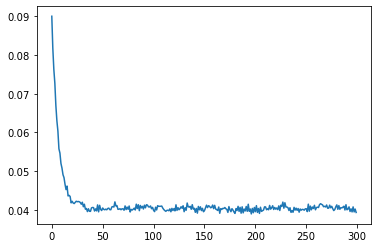

In [ ]:
# Training loop
for epoch in range(1):
  print(f"Epoch {epoch+1}")
  tqdm_train_data = tqdm(train_data)
  for images, labels in tqdm_train_data:
    step += 1
    x0 = images.flatten(start_dim=1)
    batch_dim = x0.shape[0]
    x1 = torch.zeros((batch_dim, hidden1_features))
    x2 = torch.zeros((batch_dim, hidden2_features))
    x3 = torch.zeros((batch_dim, out_features))

    x4 = onehot(labels, n_classes=10) # Constrain output to be the correct labels.

    x4_pred = activation3(activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2) @ W3.T + b3)

    loss = -(torch.log(x4_pred) * x4).sum(dim=1).mean()
    tqdm_train_data.set_description(f"Training - Loss: {loss:.4f} - Accuracy: {accuracy*100:.2f}%")
    loss_history.append((step, loss))
    errors_history = []

    # Run predictive coding inference. 
    for t in range(300):
      u1 = x0 @ W1.T + b1
      u2 = activation1(x1) @ W2.T + b2
      u3 = activation2(x2) @ W3.T + b3
      u4 = activation3(x3)

      # Calculate errors
      e1 = x1 - u1
      e2 = x2 - u2
      e3 = x3 - u3
      e4 = x4 - u4

      # Canculate derivatives
      dx1 = -e1 + activation1(x1, deriv=True) * (e2 @ W2)
      dx2 = -e2 + activation2(x2, deriv=True) * (e3 @ W3)
      dx3 = -e3 + activation3(x3, deriv=True) * (e4)
      #dx4 = -e4 # Only do this during prediction

      # Do actual steps
      x1 += ir * dx1
      x2 += ir * dx2
      x3 += ir * dx3
      #x4 -= ir * dx4 # Only do this during inference.

      if test:
        errors_history.append(((e1 ** 2).mean(), (e2 ** 2).mean(), (e3 ** 2).mean(), (e4 ** 2).mean()))

    error_histories = zip(*errors_history)
    for error_history in error_histories:
      plt.plot(error_history)
      plt.show()
      
    if test:
      break

    # Calculate gradients
    dW1 = e1[:, :, None] @ x0[:, None, :]
    dW2 = e2[:, :, None] @ activation1(x1)[:, None, :]
    dW3 = e3[:, :, None] @ activation2(x2)[:, None, :]

    db1 = e1
    db2 = e2
    db3 = e3

    # Perform weight update here.
    W1 += lr * dW1.mean(dim=0)
    b1 += lr * db1.mean(dim=0)

    W2 += lr * dW2.mean(dim=0)
    b2 += lr * db2.mean(dim=0)

    W3 += lr * dW3.mean(dim=0)
    b3 += lr * db3.mean(dim=0)

    if step % 100 == 0:
      tqdm_train_data.set_description(f"Testing - Loss: {loss.item():.4f} - Accuracy: {accuracy*100:.2f}%")
      tested = 0
      correct = 0
      for images, labels in test_data:
        x0 = images.flatten(start_dim=1)
        pred = activation3(activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2) @ W3.T + b3)
        pred_labels = pred.argmax(dim=1)

        tested += len(pred_labels)
        correct += (pred_labels == labels).sum()

      accuracy = correct / tested
      accuracy_history.append((step, accuracy))

  if test:
    break

Epoch 1


  0%|          | 0/938 [00:00<?, ?it/s]

torch.Size([64, 32]) torch.Size([64, 32]) torch.Size([64, 10]) torch.Size([10, 32])
torch.Size([64, 32]) torch.Size([64, 32]) torch.Size([64, 10]) torch.Size([10, 32])
torch.Size([64, 32]) torch.Size([64, 32]) torch.Size([64, 10]) torch.Size([10, 32])
torch.Size([64, 32]) torch.Size([64, 32]) torch.Size([64, 10]) torch.Size([10, 32])
torch.Size([64, 32]) torch.Size([64, 32]) torch.Size([64, 10]) torch.Size([10, 32])
torch.Size([64, 32]) torch.Size([64, 32]) torch.Size([64, 10]) torch.Size([10, 32])
torch.Size([64, 32]) torch.Size([64, 32]) torch.Size([64, 10]) torch.Size([10, 32])
torch.Size([64, 32]) torch.Size([64, 32]) torch.Size([64, 10]) torch.Size([10, 32])
torch.Size([64, 32]) torch.Size([64, 32]) torch.Size([64, 10]) torch.Size([10, 32])
torch.Size([64, 32]) torch.Size([64, 32]) torch.Size([64, 10]) torch.Size([10, 32])
torch.Size([64, 32]) torch.Size([64, 32]) torch.Size([64, 10]) torch.Size([10, 32])
torch.Size([64, 32]) torch.Size([64, 32]) torch.Size([64, 10]) torch.Size([1

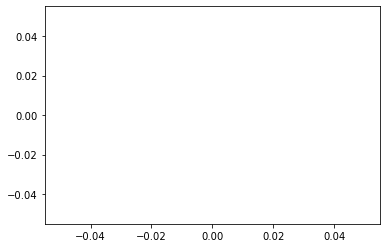

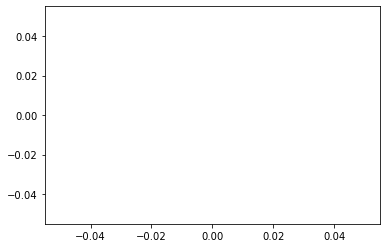

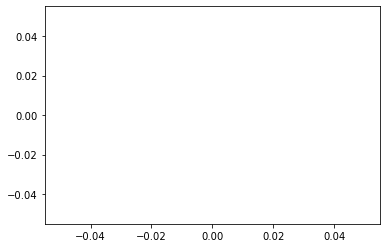

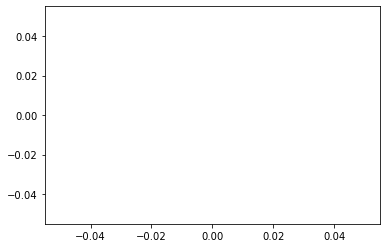

In [ ]:
# Training loop
for epoch in range(1):
  print(f"Epoch {epoch+1}")
  tqdm_train_data = tqdm(train_data)
  for images, labels in tqdm_train_data:
    step += 1
    x0 = images.flatten(start_dim=1)

    # Initialize x's with forward predictions
    x1 = u1 = x0 @ W1.T + b1
    x2 = u2 = activation1(x1) @ W2.T + b2
    x3 = u3 = activation2(x2) @ W3.T + b3
    u4 = activation3(x3)

    x4 = onehot(labels, n_classes=10) # Constrain output to be the correct labels.

    x4_pred = activation3(activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2) @ W3.T + b3)

    loss = -(torch.log(x4_pred) * x4).sum(dim=1).mean()
    tqdm_train_data.set_description(f"Training - Loss: {loss:.4f} - Accuracy: {accuracy*100:.2f}%")
    loss_history.append((step, loss))
    errors_history = []

    # Run predictive coding inference. 
    for t in range(40):
      u4 = activation3(x3)
      e4 = x4 - u4


      u3 = activation2(x2) @ W3.T + b3
      e3 = x3 - u3

      print(activation2(x2, deriv=True).shape, e2.shape, e3.shape, W3.shape)

      dx3 = -e3 + activation3(x3, deriv=True) * (e4)
      x3 += ir * dx3
      
      u2 = activation1(x1) @ W2.T + b2
      e2 = x2 - u2
      dx2 = -e2 + activation2(x2, deriv=True) * (e3 @ W3)
      x2 += ir * dx2
      
      u1 = x0 @ W1.T + b1
      e1 = x1 - u1
      dx1 = -e1 + activation1(x1, deriv=True) * (e2 @ W2)
      x1 += ir * dx1

      if test:
        errors_history.append(((e1 ** 2).mean(), (e2 ** 2).mean(), (e3 ** 2).mean(), (e4 ** 2).mean()))

    error_histories = zip(*errors_history)
    for error_history in error_histories:
      plt.plot(error_history)
      plt.show()
      
    if test:
      break

    # Calculate gradients
    dW1 = e1[:, :, None] @ x0[:, None, :]
    dW2 = e2[:, :, None] @ activation1(x1)[:, None, :]
    dW3 = e3[:, :, None] @ activation2(x2)[:, None, :]

    db1 = e1
    db2 = e2
    db3 = e3

    # Perform weight update here.
    W1 += lr * dW1.mean(dim=0)
    b1 += lr * db1.mean(dim=0)

    W2 += lr * dW2.mean(dim=0)
    b2 += lr * db2.mean(dim=0)

    W3 += lr * dW3.mean(dim=0)
    b3 += lr * db3.mean(dim=0)

    if step % 100 == 0:
      tqdm_train_data.set_description(f"Testing - Loss: {loss.item():.4f} - Accuracy: {accuracy*100:.2f}%")
      tested = 0
      correct = 0
      for images, labels in test_data:
        x0 = images.flatten(start_dim=1)
        pred = activation3(activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2) @ W3.T + b3)
        pred_labels = pred.argmax(dim=1)

        tested += len(pred_labels)
        correct += (pred_labels == labels).sum()

      accuracy = correct / tested
      accuracy_history.append((step, accuracy))

  if test:
    break

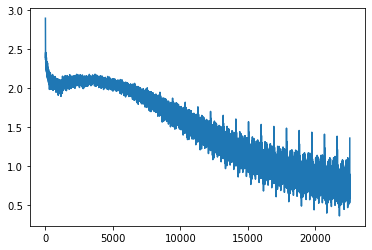

In [ ]:
plt.plot(*zip(*loss_history))
plt.show()

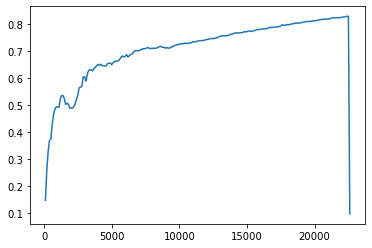

In [ ]:
plt.plot(*zip(*accuracy_history))
plt.show()

In [ ]:
# torch.save((W1, b1, W2, b2, W3, b3), "../results/inference-learning/model_1-epoch.pt")
# torch.save(loss_history, "../results/inference-learning/loss-history_1-epoch.pt")
# torch.save(accuracy_history, "../results/inference-learning/accuracy-history_1-epoch.pt")

In [ ]:
tested = 0
correct = 0
for images, labels in test_data:
  x0 = images.flatten(start_dim=1)
  pred = activation3(activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2) @ W3.T + b3)
  pred_labels = pred.argmax(dim=1)

  tested += len(pred_labels)
  correct += (pred_labels == labels).sum()

accuracy = correct / tested
accuracy_history.append((step, accuracy))
print(accuracy)

tensor(0.9244)


# Zero Divergent Inference Learning

In [ ]:
# Define out layer sizes
in_features = 784
hidden1_features = 32
hidden2_features = 32
out_features = 10

# Define weights and biases
W1, b1 = get_weights_and_biases(in_features, hidden1_features)
W2, b2 = get_weights_and_biases(hidden1_features, hidden2_features)
W3, b3 = get_weights_and_biases(hidden2_features, out_features)

activation1 = leaky_relu
activation2 = leaky_relu
activation3 = softmax

In [ ]:
accuracy_history = []
loss_history = []
accuracy = 0
loss = 0
step = 0

In [ ]:
# Setup hyperparameters
ir = 1 # Inference rate (has to be 1 for Z-IL)
lr = 1e-1 # Learning rate

# Should we just test the inference part
test = False

In [ ]:
# Training loop
for epoch in range(1):
  print(f"Epoch {epoch+1}")
  tqdm_train_data = tqdm(train_data)
  for images, labels in tqdm_train_data:
    step += 1
    x0 = images.flatten(start_dim=1)
    batch_dim = x0.shape[0]

    u1 = x1 = x0 @ W1.T + b1
    u2 = x2 = activation1(x1) @ W2.T + b2
    u3 = x3 = activation2(x2) @ W3.T + b3
    u4 = x4_pred = activation3(x3)

    x4 = onehot(labels, n_classes=10) # Constrain output to be the correct labels.
    loss = -(torch.log(x4_pred) * x4).sum(dim=1).mean()
    if step % 10 == 0:
      tqdm_train_data.set_description(f"Training - Loss: {loss:.4f} - Accuracy: {accuracy*100:.2f}%")
    loss_history.append((step, loss))

    for t in range(6):
      # Calculate errors
      u1 = x0 @ W1.T + b1
      u2 = activation1(x1) @ W2.T + b2
      u3 = activation2(x2) @ W3.T + b3
      u4 = activation3(x3)

      e4 = x4 - u4
      #dx4 = -e4 # Only do this during inference
      #x4 -= ir * dx4 # Only do this during inference.

      e3 = x3 - u3
      dx3 = -e3 + activation3(x3, deriv=True) * (e4)
      x3 += ir * dx3

      e2 = x2 - u2
      dx2 = -e2 + activation2(x2, deriv=True) * (e3 @ W3)
      x2 += ir * dx2

      e1 = x1 - u1
      dx1 = -e1 + activation1(x1, deriv=True) * (e2 @ W2)
      x1 += ir * dx1


      if t == 1:
        dW3 = e3[:, :, None] @ activation2(x2)[:, None, :]
        db3 = e3
        W3 += lr * dW3.mean(dim=0)
        b3 += lr * db3.mean(dim=0)
      elif t == 2:
        dW2 = e2[:, :, None] @ activation1(x1)[:, None, :]
        db2 = e2
        W2 += lr * dW2.mean(dim=0)
        b2 += lr * db2.mean(dim=0)
      elif t == 3:
        dW1 = e1[:, :, None] @ x0[:, None, :]
        db1 = e1
        W1 += lr * dW1.mean(dim=0)
        b1 += lr * db1.mean(dim=0)
      
    if test:
      break

    if step % 100 == 0:
      tqdm_train_data.set_description(f"Testing - Loss: {loss:.4f} - Accuracy: {accuracy*100:.2f}%")
      tested = 0
      correct = 0
      for images, labels in test_data:
        x0 = images.flatten(start_dim=1)
        pred = activation3(activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2) @ W3.T + b3)
        pred_labels = pred.argmax(dim=1)

        tested += len(pred_labels)
        correct += (pred_labels == labels).sum()

      accuracy = correct / tested
      accuracy_history.append((step, accuracy))

  if test:
    break

Epoch 1


  0%|          | 0/938 [00:00<?, ?it/s]

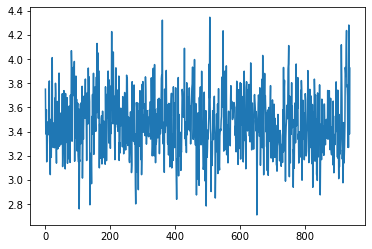

In [ ]:
plt.plot(*zip(*loss_history))
plt.show()

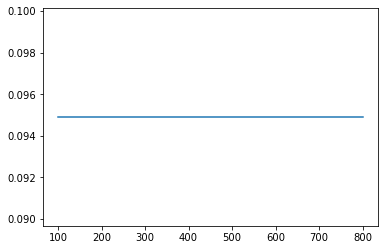

In [ ]:
plt.plot(*zip(*accuracy_history[:-1]))
plt.show()

# Experiment

In [9]:
hidden_dim = 300
W1, b1 = get_weights_and_biases(28*28, hidden_dim)
W2, b2 = get_weights_and_biases(hidden_dim, hidden_dim)
W3, b3 = get_weights_and_biases(hidden_dim, 10)
activation1 = scaled_soft_rate
activation2 = scaled_soft_rate

In [10]:
W1_og = W1.clone()
b1_og = b1.clone()
W2_og = W2.clone()
b2_og = b2.clone()
W3_og = W3.clone()
b3_og = b3.clone()

In [11]:
 W1 = W1_og.clone() * T_REF
 b1 = b1_og.clone()
 W2 = W2_og.clone()
 b2 = b2_og.clone()
 W3 = W3_og.clone()
 b3 = b3_og.clone()

## Backprop

In [693]:
# Baseline backprop model
class MLP(nn.Module):
  def __init__(self, in_features, hidden_features, out_features):
    super().__init__()
    self.l1 = nn.Linear(in_features, hidden_features)
    self.l2 = nn.Linear(hidden_features, hidden_features)
    self.l3 = nn.Linear(hidden_features, out_features)
    self.bn1 = nn.BatchNorm1d(hidden_features, affine=False)
    self.bn2 = nn.BatchNorm1d(hidden_features, affine=False)

    with torch.no_grad():
      self.l1.weight.copy_(W1)
      self.l1.bias.copy_(b1)
      self.l2.weight.copy_(W2)
      self.l2.bias.copy_(b2)
      self.l3.weight.copy_(W3)
      self.l3.bias.copy_(b3)

  def forward(self, x):
    x = self.l1(x)
    x = self.bn1(x)
    x = activation1(x)
    x = self.l2(x)
    x = self.bn2(x)
    x = activation2(x)
    x = self.l3(x)
    return x


model = MLP(28*28, hidden_dim, 10)

In [694]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [695]:
step = 0
accuracy = 0
loss_history = []
accuracy_history = []

In [696]:
model.train()
for epoch in range(1):
  print(f"Epoch {epoch+1}")
  tqdm_train_data = tqdm(train_data)
  for images, labels in tqdm_train_data:
    step += 1

    optimizer.zero_grad()
    x0 = images.flatten(start_dim=1) / T_REF

    pred = model(x0)
    loss = criterion(pred, labels)
    loss.backward()
    
    loss_history.append((step, loss.item()))

    tqdm_train_data.set_description(f"Training - Loss: {loss.item():.4f} - Accuracy: {accuracy*100:.2f}%")

    optimizer.step()

    if step % 100 == 0: 
      model.eval()
      tqdm_train_data.set_description(f"Testing - Loss: {loss.item():.4f} - Accuracy: {accuracy*100:.2f}%")
      tested = 0
      correct = 0
      for images, labels in test_data:
        x0 = images.flatten(start_dim=1) / T_REF
        x3_pred = model(x0) 
        pred_labels = x3_pred.argmax(dim=1)

        tested += len(pred_labels)
        correct += (pred_labels == labels).sum()
      accuracy = correct / tested
      

      accuracy_history.append((step, accuracy))
      model.train()
    

Epoch 1


  0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: 

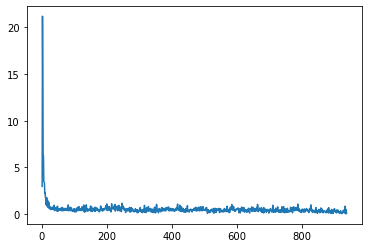

In [93]:
plt.plot(*zip(*loss_history))
plt.show()

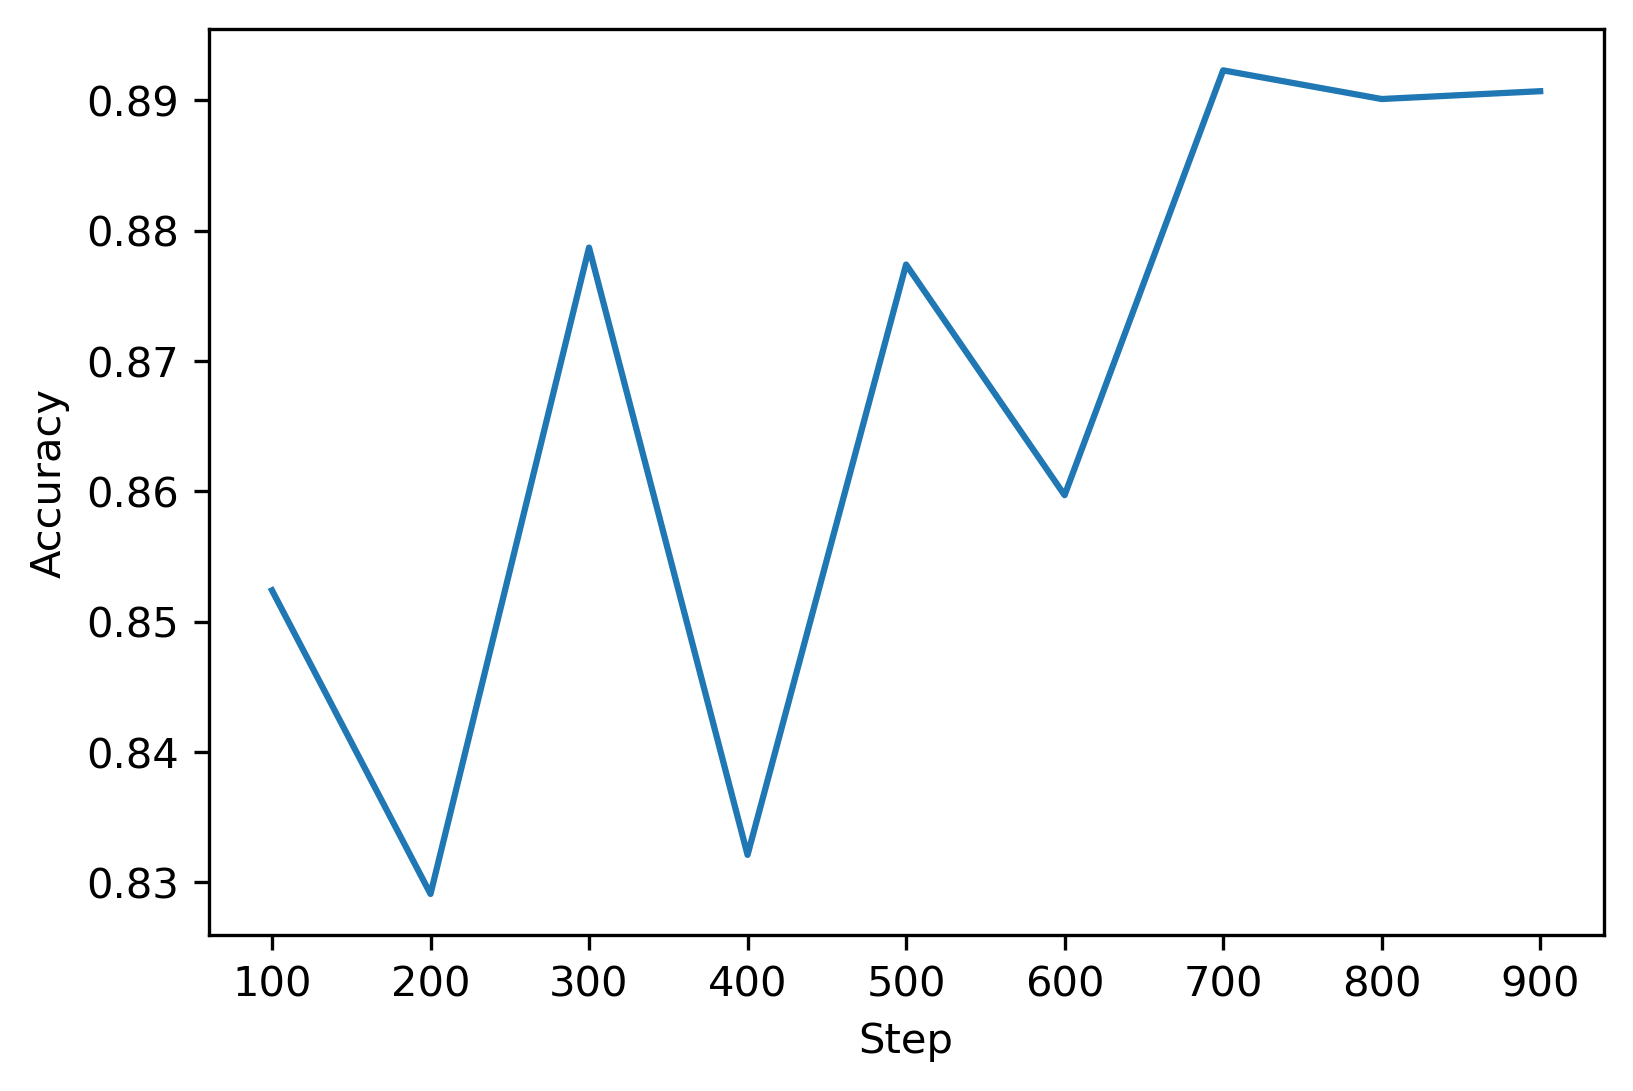

In [94]:
plt.figure(dpi=300)
plt.plot(*zip(*accuracy_history))
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.show()

In [165]:
torch.save(accuracy_history, "../results/predictive-coding/backprop/accuracy_history.pt")
torch.save(loss_history, "../results/predictive-coding/backprop/loss_history.pt")

backprop_accuracy_history = accuracy_history
backprop_loss_history = loss_history

In [24]:
tested = 0
correct = 0
for images, labels in test_data:
  x0 = images.flatten(start_dim=1)
  pred = model(x0)
  pred_labels = pred.argmax(dim=1)

  tested += len(pred_labels)
  correct += (pred_labels == labels).sum()

accuracy = correct / tested
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 96.77%


## Inference learning

In [16]:
W1 = W1_og.clone()
b1 = b1_og.clone()
W2 = W2_og.clone()
b2 = b2_og.clone()
W3 = W3_og.clone()
b3 = b3_og.clone()

In [17]:
step = 0
accuracy = 0
loss_history = []
accuracy_history = []

In [19]:
ir = 0.1
lr = 1e-2

In [15]:
# Training loop
for epoch in range(20):
  print(f"Epoch {epoch+1}")
  tqdm_train_data = tqdm(train_data)
  for images, labels in tqdm_train_data:
    step += 1
    x0 = images.flatten(start_dim=1)
    u1 = x1 = x0 @ W1.T + b1
    u2 = x2 = activation1(x1) @ W2.T + b2
    u3 = x3 = activation2(x2) @ W3.T + b3
    u4 = softmax(x3)

    x4 = onehot(labels, n_classes=10)

    loss = -(torch.log(u4) * x4).sum(dim=1).mean()
    tqdm_train_data.set_description(f"Training - Loss: {loss.item():.4f} - Accuracy: {accuracy*100:.2f}%")
    loss_history.append((step, loss))


    e1 = x1 - u1
    e2 = x2 - u2
    e3 = x3 - u3
    e4 = x4 - u4
  
    # errors = []
    # errors.append((e1.abs().mean(), e2.abs().mean(), e3.abs().mean(), e4.abs().mean()))
    # f_history = [f_0]

    f_0 = (e1 ** 2).sum() + (e2 ** 2).sum() + (e3 ** 2).sum() + (e4 ** 2).sum()
    beta = ir
    for i in range(50):
      dx3 = -e3 + e4
      x3 += beta * dx3

      dx2 = -e2 + activation2(x2, deriv=True) * (e3 @ W3)
      x2 += beta * dx2

      dx1 = -e1 + activation1(x1, deriv=True) * (e2 @ W2)
      x1 += beta * dx1

      # x3 is clamped

      u4 = softmax(x3)
      e4 = x4 - u4

      u3 = activation2(x2) @ W3.T + b3
      e3 = x3 - u3

      u2 = activation1(x1) @ W2.T + b2
      e2 = x2 - u2

      u1 = x0 @ W1.T + b1
      e1 = x1 - u1

      f = (e1 ** 2).sum() + (e2 ** 2).sum() + (e3 ** 2).sum() + (e4 ** 2).sum()

      diff = f - f_0
      if diff > 0:
        beta *= 0.9

    #   f_history.append(f)
    #   errors.append((e1.abs().mean(), e2.abs().mean(), e3.abs().mean(), e4.abs().mean()))

    # for errors in zip(*errors):
    #   plt.plot(errors)
    #   plt.show()
    
    # plt.plot(f_history)
    # plt.show()
    # break 
  
    dW1 = e1[:, :, None] @ (x0)[:, None, :]
    db1 = e1
    dW2 = e2[:, :, None] @ activation1(x1)[:, None, :]
    db2 = e2
    dW3 = e3[:, :, None] @ activation2(x2)[:, None, :]
    db3 = e3

    W1 += lr * dW1.mean(dim=0)
    b1 += lr * db1.mean(dim=0)

    W2 += lr * dW2.mean(dim=0)
    b2 += lr * db2.mean(dim=0)

    W3 += lr * dW3.mean(dim=0)
    b3 += lr * db3.mean(dim=0)

    if step % 200 == 0: 
      tqdm_train_data.set_description(f"Testing - Loss: {loss.item():.4f} - Accuracy: {accuracy*100:.2f}%")
      tested = 0
      correct = 0
      for images, labels in test_data:
        x0 = images.flatten(start_dim=1)
        pred = activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2) @ W3.T + b3
        pred_labels = pred.argmax(dim=1)

        tested += len(pred_labels)
        correct += (pred_labels == labels).sum()
      accuracy = correct / tested

      accuracy_history.append((step, accuracy))



Epoch 1


  0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [46]:
tqdm_train_data.set_description(f"Testing - Loss: {loss.item():.4f} - Accuracy: {accuracy*100:.2f}%")
tested = 0
correct = 0
for images, labels in test_data:
  x0 = images.flatten(start_dim=1)
  pred = activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2) @ W3.T + b3
  pred_labels = pred.argmax(dim=1)

  tested += len(pred_labels)
  correct += (pred_labels == labels).sum()
accuracy = correct / tested
print(accuracy)

tensor(0.5082)


In [1]:
plt.plot(*zip(*loss_history))
plt.show()

NameError: name 'plt' is not defined

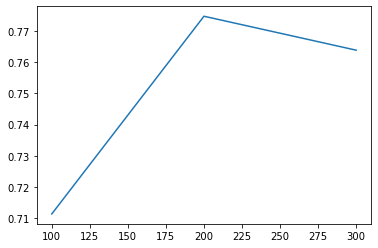

In [80]:
plt.plot(*zip(*accuracy_history))
plt.show()

## Z-IL

In [77]:
W1 = W1_og.clone() * T_REF
b1 = b1_og.clone()
W2 = W2_og.clone()
b2 = b2_og.clone()
W3 = W3_og.clone()
b3 = b3_og.clone()

In [78]:
step = 0
accuracy = 0
loss_history = []
accuracy_history = []

In [79]:
lr = 1e-3

In [80]:
# Z-IL
# Training loop
for epoch in range(20):
  print(f"Epoch {epoch+1}")
  tqdm_train_data = tqdm(train_data)
  for images, labels in tqdm_train_data:
    step += 1
    x0 = images.flatten(start_dim=1) / T_REF
    u1 = x1 = x0 @ W1.T + b1
    u2 = x2 = activation1(x1) @ W2.T + b2
    u3 = x3 = activation2(x2) @ W3.T + b3
    u4 = softmax(x3)

    x4 = onehot(labels, n_classes=10)

    loss = -(torch.log(u4) * x4).sum(dim=1).mean()
    tqdm_train_data.set_description(f"Training - Loss: {loss.item():.4f} - Accuracy: {accuracy*100:.2f}%")
    loss_history.append((step, loss))

    # errors = []
    for t in range(4):
      u1 = x0 @ W1.T + b1
      u2 = activation1(x1) @ W2.T + b2
      u3 = activation2(x2) @ W3.T + b3
      u4 = softmax(x3)

      e4 = x4 - u4

      e3 = x3 - u3
      dx3 = -e3 + e4
      x3 += dx3

      if t == 1:
        dW3 = e3[:, :, None] @ activation2(x2)[:, None, :]
        db3 = e3
        W3 += lr * dW3.mean(dim=0)
        b3 += lr * db3.mean(dim=0)

      e2 = x2 - u2
      dx2 = -e2 + activation2(x2, deriv=True) * (e3 @ W3)
      x2 += dx2

      if t == 2:
        dW2 = e2[:, :, None] @ activation1(x1)[:, None, :]
        db2 = e2
        W2 += lr * dW2.mean(dim=0)
        b2 += lr * db2.mean(dim=0)

      e1 = x1 - u1
      dx1 = -e1 + activation1(x1, deriv=True) * (e2 @ W2)
      x1 += dx1

      if t == 3:
        dW1 = e1[:, :, None] @ x0[:, None, :]
        db1 = e1
        W1 += lr * dW1.mean(dim=0)
        b1 += lr * db1.mean(dim=0)

      #print(e1.abs().mean(), e2.abs().mean(), e3.abs().mean())
    #break

    if step % 100 == 0: 
      tqdm_train_data.set_description(f"Testing - Loss: {loss.item():.4f} - Accuracy: {accuracy*100:.2f}%")
      tested = 0
      correct = 0
      for images, labels in test_data:
        x0 = images.flatten(start_dim=1) / T_REF
        pred = activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2) @ W3.T + b3
        pred_labels = pred.argmax(dim=1)

        tested += len(pred_labels)
        correct += (pred_labels == labels).sum()
      accuracy = correct / tested

      accuracy_history.append((step, accuracy))

Epoch 1


  0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Z-IL with Adam

In [697]:
W1 = W1_og.clone() * T_REF
b1 = b1_og.clone()
W2 = W2_og.clone()
b2 = b2_og.clone()
W3 = W3_og.clone()
b3 = b3_og.clone()

In [698]:
step = 0
accuracy = 0
loss_history = []
accuracy_history = []

In [699]:
lr = 1e-3

In [700]:
# Prepare for adam
beta1 = 0.9
beta2 = 0.999
m1 = torch.zeros_like(W1)
m2 = torch.zeros_like(W2)
m3 = torch.zeros_like(W3)
mb1 = torch.zeros_like(b1)
mb2 = torch.zeros_like(b2)
mb3 = torch.zeros_like(b3)
v1 = torch.zeros_like(W1)
v2 = torch.zeros_like(W2)
v3 = torch.zeros_like(W3)
vb1 = torch.zeros_like(b1)
vb2 = torch.zeros_like(b2)
vb3 = torch.zeros_like(b3)
epsilon = 1e-8

In [677]:
# Z-IL with Adam
# Training loop
for epoch in range(1):
  print(f"Epoch {epoch+1}")
  tqdm_train_data = tqdm(train_data)
  for images, labels in tqdm_train_data:
    step += 1
    x0 = images.flatten(start_dim=1) / T_REF
    u1 = x1 = x0 @ W1.T + b1
    u2 = x2 = activation1(x1) @ W2.T + b2
    u3 = x3 = activation2(x2) @ W3.T + b3
    u4 = softmax(x3)

    x4 = onehot(labels, n_classes=10)

    loss = -(torch.log(u4) * x4).sum(dim=1).mean()
    tqdm_train_data.set_description(f"Training - Loss: {loss.item():.4f} - Accuracy: {accuracy*100:.2f}%")
    loss_history.append((step, loss))

    for t in range(4):
      u1 = x0 @ W1.T + b1
      u2 = activation1(x1) @ W2.T + b2
      u3 = activation2(x2) @ W3.T + b3
      u4 = softmax(x3)

      e4 = x4 - u4

      e3 = x3 - u3
      dx3 = -e3 + e4
      x3 += dx3

      if t == 1:
        dW3 = e3[:, :, None] @ activation2(x2)[:, None, :]
        db3 = e3
        m3 = beta1 * m3 + (1 - beta1) * dW3.mean(dim=0)
        mb3 = beta1 * mb3 + (1 - beta1) * db3.mean(dim=0)
        v3 = beta2 * v3 + (1 - beta2) * dW3.pow(2).mean(dim=0)
        vb3 = beta2 * vb3 + (1 - beta2) * db3.pow(2).mean(dim=0)

        W3 += lr * math.sqrt(1 - beta2**step) / (1 - beta1**step) * m3 / torch.sqrt(v3 + epsilon)
        b3 += lr * math.sqrt(1 - beta2**step) / (1 - beta1**step) * mb3 / torch.sqrt(vb3 + epsilon)

      e2 = x2 - u2
      dx2 = -e2 + activation2(x2, deriv=True) * (e3 @ W3)
      x2 += dx2

      if t == 2:
        dW2 = e2[:, :, None] @ activation1(x1)[:, None, :]
        db2 = e2
        m2 = beta1 * m2 + (1 - beta1) * dW2.mean(dim=0)
        mb2 = beta1 * mb2 + (1 - beta1) * db2.mean(dim=0)
        v2 = beta2 * v2 + (1 - beta2) * dW2.pow(2).mean(dim=0)
        vb2 = beta2 * vb2 + (1 - beta2) * db2.pow(2).mean(dim=0)

        W2 += lr * math.sqrt(1 - beta2**step) / (1 - beta1**step) * m2 / torch.sqrt(v2 + epsilon)
        b2 += lr * math.sqrt(1 - beta2**step) / (1 - beta1**step) * mb2 / torch.sqrt(vb2 + epsilon)


      e1 = x1 - u1
      dx1 = -e1 + activation1(x1, deriv=True) * (e2 @ W2)
      x1 += dx1

      if t == 3:
        dW1 = e1[:, :, None] @ x0[:, None, :]
        db1 = e1

        m1 = beta1 * m1 + (1 - beta1) * dW1.mean(dim=0)
        mb1 = beta1 * mb1 + (1 - beta1) * db1.mean(dim=0)
        v1 = beta2 * v1 + (1 - beta2) * dW1.pow(2).mean(dim=0)
        vb1 = beta2 * vb1 + (1 - beta2) * db1.pow(2).mean(dim=0)

        W1 += lr * math.sqrt(1 - beta2**step) / (1 - beta1**step) * m1 / torch.sqrt(v1 + epsilon)
        b1 += lr * math.sqrt(1 - beta2**step) / (1 - beta1**step) * mb1 / torch.sqrt(vb1 + epsilon)

      print(t, e1.abs().mean(), e2.abs().mean(), e3.abs().mean())
    break

    if step % 100 == 0: 
      tqdm_train_data.set_description(f"Testing - Loss: {loss.item():.4f} - Accuracy: {accuracy*100:.2f}%")
      tested = 0
      correct = 0
      for images, labels in test_data:
        x0 = images.flatten(start_dim=1) / T_REF
        pred = activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2) @ W3.T + b3
        pred_labels = pred.argmax(dim=1)

        tested += len(pred_labels)
        correct += (pred_labels == labels).sum()
      accuracy = correct / tested

      accuracy_history.append((step, accuracy))

Epoch 1


  0%|          | 0/938 [00:00<?, ?it/s]

0 tensor(0.) tensor(0.) tensor(0.)
1 tensor(0.) tensor(0.) tensor(0.1803)
2 tensor(0.) tensor(0.0350) tensor(0.4016)
3 tensor(0.0546) tensor(0.4478) tensor(1.5483)


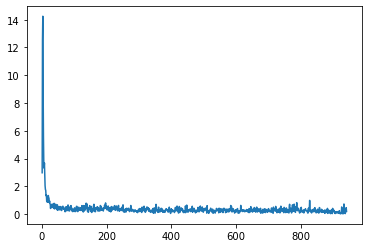

In [105]:
plt.plot(*zip(*loss_history))
plt.show()

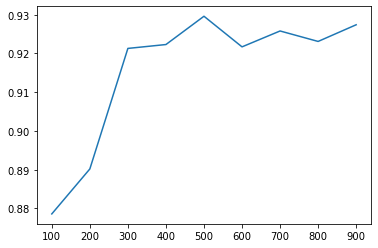

In [106]:
plt.plot(*zip(*accuracy_history))
plt.show()

## Z-IL with Adam and batch norm

In [743]:
W1 = W1_og.clone() * T_REF
b1 = b1_og.clone()
W2 = W2_og.clone()
b2 = b2_og.clone()
W3 = W3_og.clone()
b3 = b3_og.clone()

In [744]:
step = 0
accuracy = 0
loss_history = []
accuracy_history = []

In [16]:
# Prepare for batch norm
x1_bn_w = torch.ones(W1.shape[0])
x1_bn_b = torch.zeros(W1.shape[0])
x1_bn_mean = torch.zeros(W1.shape[0])
x1_bn_var = torch.ones(W1.shape[0])

x2_bn_w = torch.ones(W2.shape[0])
x2_bn_b = torch.zeros(W2.shape[0])
x2_bn_mean = torch.zeros(W2.shape[0])
x2_bn_var = torch.ones(W2.shape[0])

alpha = 0.1

# Prepare for adam
beta1 = 0.9
beta2 = 0.999
m1 = torch.zeros_like(W1)
m1_bn = torch.zeros_like(x1_bn_w)

m2 = torch.zeros_like(W2)
m2_bn = torch.zeros_like(x2_bn_w)

m3 = torch.zeros_like(W3)

mb1 = torch.zeros_like(b1)
mb1_bn = torch.zeros_like(x1_bn_b)

mb2 = torch.zeros_like(b2)
mb2_bn = torch.zeros_like(x2_bn_b)

mb3 = torch.zeros_like(b3)

v1 = torch.zeros_like(W1)
v1_bn = torch.zeros_like(x1_bn_w)

v2 = torch.zeros_like(W2)
v2_bn = torch.zeros_like(x2_bn_w)

v3 = torch.zeros_like(W3)

vb1 = torch.zeros_like(b1)
vb1_bn = torch.zeros_like(x1_bn_b)

vb2 = torch.zeros_like(b2)
vb2_bn = torch.zeros_like(x2_bn_b)

vb3 = torch.zeros_like(b3)
epsilon = 1e-8

In [746]:
lr = 1e-3

In [12]:
def normalize(x):
  return (x - x.mean(dim=0)) / (x.var(dim=0, unbiased=False) + epsilon).sqrt()

def batch_norm(x, gamma, beta, dldy=None, deriv=False):
  if deriv:
    xhat = normalize(x)
    ivar = 1 / (x.var(dim=0, unbiased=False) + epsilon).sqrt()
    dldxhat = gamma * dldy
    dldvar = torch.sum(dldxhat * (x - x.mean(dim=0)), dim=0) * (-0.5) * (x.var(dim=0, unbiased=False) + epsilon).sqrt().pow(-3)
    dldmean = torch.sum(-dldxhat / (x.var(dim=0, unbiased=False) + epsilon).sqrt(), dim=0) + dldvar * torch.sum(-2 * (x - x.mean(dim=0)), dim=0) / x.shape[0]
    dldgamma = torch.sum(dldy * xhat, dim=0)
    dldbeta = torch.sum(dldy, dim=0)
    dldx = dldxhat * ivar + dldvar * 2 * (x - x.mean(dim=0)) / x.shape[0] + dldmean / x.shape[0]
    
    return dldx, dldgamma, dldbeta
  else:
    return gamma * normalize(x) + beta

In [34]:
x = torch.tensor([
  [1., 2., 3.], 
  [3., 7., 12.], 
  [3., 6., 9.]
])

y = torch.tensor([
  [1., 2., 5.], 
  [3., 8., 12.], 
  [12., 6., 12.]
])

x_bn = batch_norm(x, torch.ones(x.shape[1]), torch.zeros(x.shape[1]))
y_bn = batch_norm(y, torch.ones(x.shape[1]), torch.zeros(x.shape[1]))

e = x_bn - y_bn

print("x_bn\n", x_bn)
print("y_bn\n", y_bn)

print(x_bn + batch_norm(x, torch.ones(x.shape[1]), torch.zeros(x.shape[1]), dldy=e, deriv=True)[0])
print(y_bn)


x_bn
 tensor([[-1.4142, -1.3887, -1.3363],
        [ 0.7071,  0.9258,  1.0690],
        [ 0.7071,  0.4629,  0.2673]])
y_bn
 tensor([[-0.9058, -1.3363, -1.4142],
        [-0.4877,  1.0690,  0.7071],
        [ 1.3935,  0.2673,  0.7071]])
tensor([[-1.4142, -1.4064, -1.2958],
        [ 1.7048,  0.8551,  1.1500],
        [-0.2905,  0.5513,  0.1458]])
tensor([[-0.9058, -1.3363, -1.4142],
        [-0.4877,  1.0690,  0.7071],
        [ 1.3935,  0.2673,  0.7071]])


In [749]:
# Z-IL with Adam and batch norm!
# Training loop
for epoch in range(20):
  print(f"Epoch {epoch+1}")
  tqdm_train_data = tqdm(train_data)
  for images, labels in tqdm_train_data:
    step += 1
    x0 = images.flatten(start_dim=1) / T_REF
    u1 = x1 = x0 @ W1.T + b1
    u1_bn = x1_bn = batch_norm(x1, x1_bn_w, x1_bn_b)

    x1_bn_mean = alpha * x1_bn_mean + (1 - alpha) * x1.mean(dim=0)
    x1_bn_var = alpha * x1_bn_var + (1 - alpha) * x1.var(dim=0)

    u2 = x2 = activation1(x1_bn) @ W2.T + b2
    u2_bn = x2_bn = batch_norm(x2, x2_bn_w, x2_bn_b)

    x2_bn_mean = alpha * x2_bn_mean + (1 - alpha) * x2.mean(dim=0)
    x2_bn_var = alpha * x2_bn_var + (1 - alpha) * x2.var(dim=0)

    u3 = x3 = activation2(x2_bn) @ W3.T + b3
    u4 = softmax(x3)

    x4 = onehot(labels, n_classes=10)

    loss = -(torch.log(u4) * x4).sum(dim=1).mean()
    tqdm_train_data.set_description(f"Training - Loss: {loss.item():.4f} - Accuracy: {accuracy*100:.2f}%")
    loss_history.append((step, loss))

    for t in range(6):
      u1 = x0 @ W1.T + b1
      u1_bn = batch_norm(x1, x1_bn_w, x1_bn_b)
      u2 = activation1(x1_bn) @ W2.T + b2
      u2_bn = batch_norm(x2, x2_bn_w, x2_bn_b)
      u3 = activation2(x2_bn) @ W3.T + b3
      u4 = softmax(x3)

      e4 = x4 - u4

      # Layer 3
      e3 = x3 - u3
      dx3 = -e3 + e4
      x3 += dx3

      if t == 1:
        dW3 = e3[:, :, None] @ activation2(x2_bn)[:, None, :]
        db3 = e3

        m3 = beta1 * m3 + (1 - beta1) * dW3.mean(dim=0)
        mb3 = beta1 * mb3 + (1 - beta1) * db3.mean(dim=0)
        v3 = beta2 * v3 + (1 - beta2) * dW3.pow(2).mean(dim=0)
        vb3 = beta2 * vb3 + (1 - beta2) * db3.pow(2).mean(dim=0)

        W3 += lr * math.sqrt(1 - beta2**step) / (1 - beta1**step) * m3 / torch.sqrt(v3 + epsilon)
        b3 += lr * math.sqrt(1 - beta2**step) / (1 - beta1**step) * mb3 / torch.sqrt(vb3 + epsilon)

      # Layer 2 batch norm
      e2_bn = x2_bn - u2_bn
      dx2_bn = -e2_bn + activation2(x2_bn, deriv=True) * (e3 @ W3)
      x2_bn += dx2_bn

      if t == 2:
        _, dx2_bn_w, dx2_bn_b = batch_norm(x2, x2_bn_w, x2_bn_b, dldy=e2_bn, deriv=True)

        m2_bn = beta1 * m2_bn + (1 - beta1) * dx2_bn_w.mean(dim=0)
        mb2_bn = beta1 * mb2_bn + (1 - beta1) * dx2_bn_b.mean(dim=0)
        v2_bn = beta2 * v2_bn + (1 - beta2) * dx2_bn_w.pow(2).mean(dim=0)
        vb2_bn = beta2 * vb2_bn + (1 - beta2) * dx2_bn_b.pow(2).mean(dim=0)

        x2_bn_w += lr * math.sqrt(1 - beta2**step) / (1 - beta1**step) * m2_bn / torch.sqrt(v2_bn + epsilon)
        x2_bn_b += lr * math.sqrt(1 - beta2**step) / (1 - beta1**step) * mb2_bn / torch.sqrt(vb2_bn + epsilon)

      # Layer 2
      e2 = x2 - u2
      dx2 = -e2 + batch_norm(x2, x2_bn_w, x2_bn_b, dldy=e2_bn, deriv=True)[0]
      x2 += dx2

      if t == 3:
        dW2 = e2[:, :, None] @ activation1(x1_bn)[:, None, :]
        db2 = e2

        m2 = beta1 * m2 + (1 - beta1) * dW2.mean(dim=0)
        mb2 = beta1 * mb2 + (1 - beta1) * db2.mean(dim=0)
        v2 = beta2 * v2 + (1 - beta2) * dW2.pow(2).mean(dim=0)
        vb2 = beta2 * vb2 + (1 - beta2) * db2.pow(2).mean(dim=0)

        W2 += lr * math.sqrt(1 - beta2**step) / (1 - beta1**step) * m2 / torch.sqrt(v2 + epsilon)
        b2 += lr * math.sqrt(1 - beta2**step) / (1 - beta1**step) * mb2 / torch.sqrt(vb2 + epsilon)


      # Layer 1 batch norm
      e1_bn = x1_bn - u1_bn
      dx1_bn = -e1_bn + activation1(x1_bn, deriv=True) * (e2 @ W2)
      x1_bn += dx1_bn

      if t == 4:
        _, dx1_bn_w, dx1_bn_b = batch_norm(x1, x1_bn_w, x1_bn_b, dldy=e1_bn, deriv=True)

        m1_bn = beta1 * m1_bn + (1 - beta1) * dx1_bn_w.mean(dim=0)
        mb1_bn = beta1 * mb1_bn + (1 - beta1) * dx1_bn_b.mean(dim=0)
        v1_bn = beta2 * v1_bn + (1 - beta2) * dx1_bn_w.pow(2).mean(dim=0)
        vb1_bn = beta2 * vb1_bn + (1 - beta2) * dx1_bn_b.pow(2).mean(dim=0)

        x1_bn_w += lr * math.sqrt(1 - beta2**step) / (1 - beta1**step) * m1_bn / torch.sqrt(v1_bn + epsilon)
        x1_bn_b += lr * math.sqrt(1 - beta2**step) / (1 - beta1**step) * mb1_bn / torch.sqrt(vb1_bn + epsilon)

      # Layer 1
      e1 = x1 - u1
      dx1 = -e1 + batch_norm(x1, x1_bn_w, x1_bn_b, dldy=e1_bn, deriv=True)[0]
      x1 += dx1

      if t == 5:
        dW1 = e1[:, :, None] @ x0[:, None, :]
        db1 = e1

        m1 = beta1 * m1 + (1 - beta1) * dW1.mean(dim=0)
        mb1 = beta1 * mb1 + (1 - beta1) * db1.mean(dim=0)
        v1 = beta2 * v1 + (1 - beta2) * dW1.pow(2).mean(dim=0)
        vb1 = beta2 * vb1 + (1 - beta2) * db1.pow(2).mean(dim=0)

        W1 += lr * math.sqrt(1 - beta2**step) / (1 - beta1**step) * m1 / torch.sqrt(v1 + epsilon)
        b1 += lr * math.sqrt(1 - beta2**step) / (1 - beta1**step) * mb1 / torch.sqrt(vb1 + epsilon)

    #   print(t, e1.abs().mean(), e1_bn.abs().mean(), e2.abs().mean(), e2_bn.abs().mean(), e3.abs().mean(), e4.abs().mean())
    # break
    if step % 100 == 0: 
      tqdm_train_data.set_description(f"Testing - Loss: {loss.item():.4f} - Accuracy: {accuracy*100:.2f}%")
      tested = 0
      correct = 0
      for images, labels in test_data:
        x0 = images.flatten(start_dim=1) / T_REF
        x1 = x0 @ W1.T + b1
        x1_bn = (x1 - x1_bn_mean) / (x1_bn_var + epsilon).sqrt() * x1_bn_w + x1_bn_b
        x2 = activation1(x1_bn) @ W2.T + b2
        x2_bn = (x2 - x2_bn_mean) / (x2_bn_var + epsilon).sqrt() * x2_bn_w + x2_bn_b
        x3 = activation2(x2_bn) @ W3.T + b3

        pred_labels = x3.argmax(dim=1)

        tested += len(pred_labels)
        correct += (pred_labels == labels).sum()
      accuracy = correct / tested

      accuracy_history.append((step, accuracy))

Epoch 1


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 11


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 12


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 13


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 14


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 15


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 16


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 17


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 18


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 19


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 20


  0%|          | 0/938 [00:00<?, ?it/s]

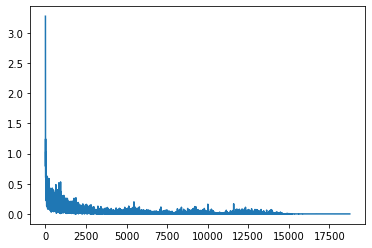

In [750]:
plt.plot(*zip(*loss_history))
plt.show()

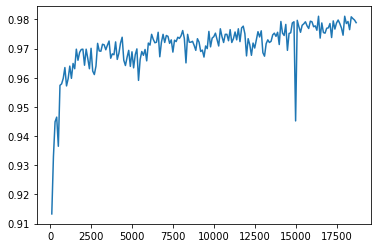

In [751]:
plt.plot(*zip(*accuracy_history))
plt.show()

In [752]:
tested = 0
correct = 0
for images, labels in test_data:
  x0 = images.flatten(start_dim=1) / T_REF
  x1 = x0 @ W1.T + b1
  x1_bn = (x1 - x1_bn_mean) / (x1_bn_var + epsilon).sqrt() * x1_bn_w + x1_bn_b
  x2 = activation1(x1_bn) @ W2.T + b2
  x2_bn = (x2 - x2_bn_mean) / (x2_bn_var + epsilon).sqrt() * x2_bn_w + x2_bn_b
  x3 = activation2(x2_bn) @ W3.T + b3

  pred_labels = x3.argmax(dim=1)

  tested += len(pred_labels)
  correct += (pred_labels == labels).sum()
accuracy = correct / tested
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 97.17%


In [174]:
zil_accuracy_history = accuracy_history
zil_loss_history = loss_history

In [742]:
torch.save((W1, b1, W2, b2, W3, b3, x1_bn_mean, x1_bn_var, x2_bn_mean, x2_bn_var), "../results/Z-IL-spiking-adam-batchnorm.pt")

In [193]:
torch.save(model.state_dict(), "../results/bp-model.pt")

In [89]:
tested = 0
correct = 0
for images, labels in test_data:
  x0 = images.flatten(start_dim=1) / T_REF
  pred = activation2(activation1(x0 @ W1.T + b1) @ W2.T + b2) @ W3.T + b3
  pred_labels = pred.argmax(dim=1)

  tested += len(pred_labels)
  correct += (pred_labels == labels).sum()

accuracy = correct / tested
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 96.94%


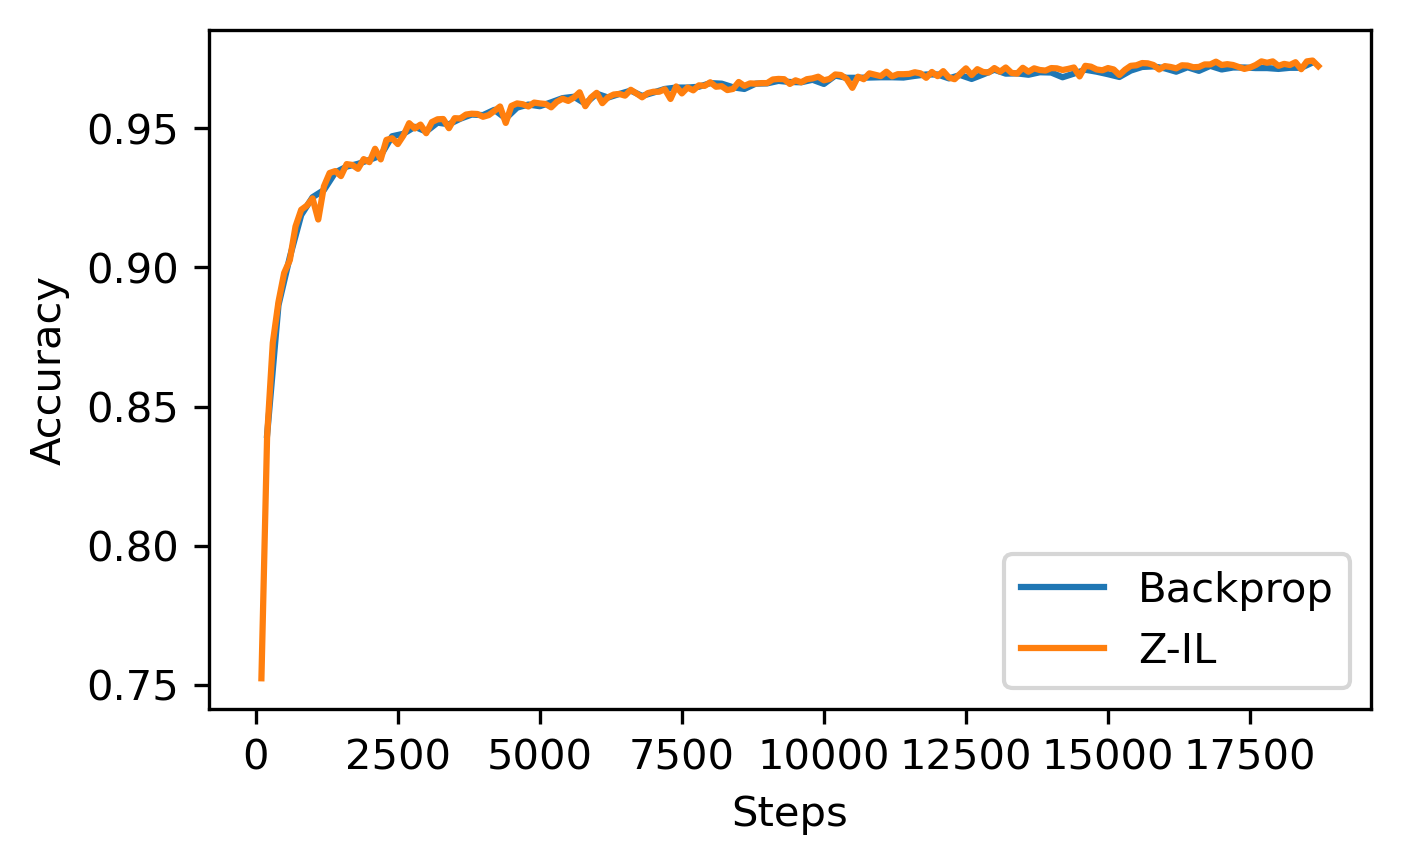

In [189]:
plt.figure(figsize=(5, 3), dpi=300)
plt.plot(*zip(*backprop_accuracy_history))
plt.plot(*zip(*zil_accuracy_history))
plt.legend(["Backprop", "Z-IL"])
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.savefig("../report/graphics/Z-IL-backprop-accuracy.pdf", bbox_inches = "tight")
plt.show()


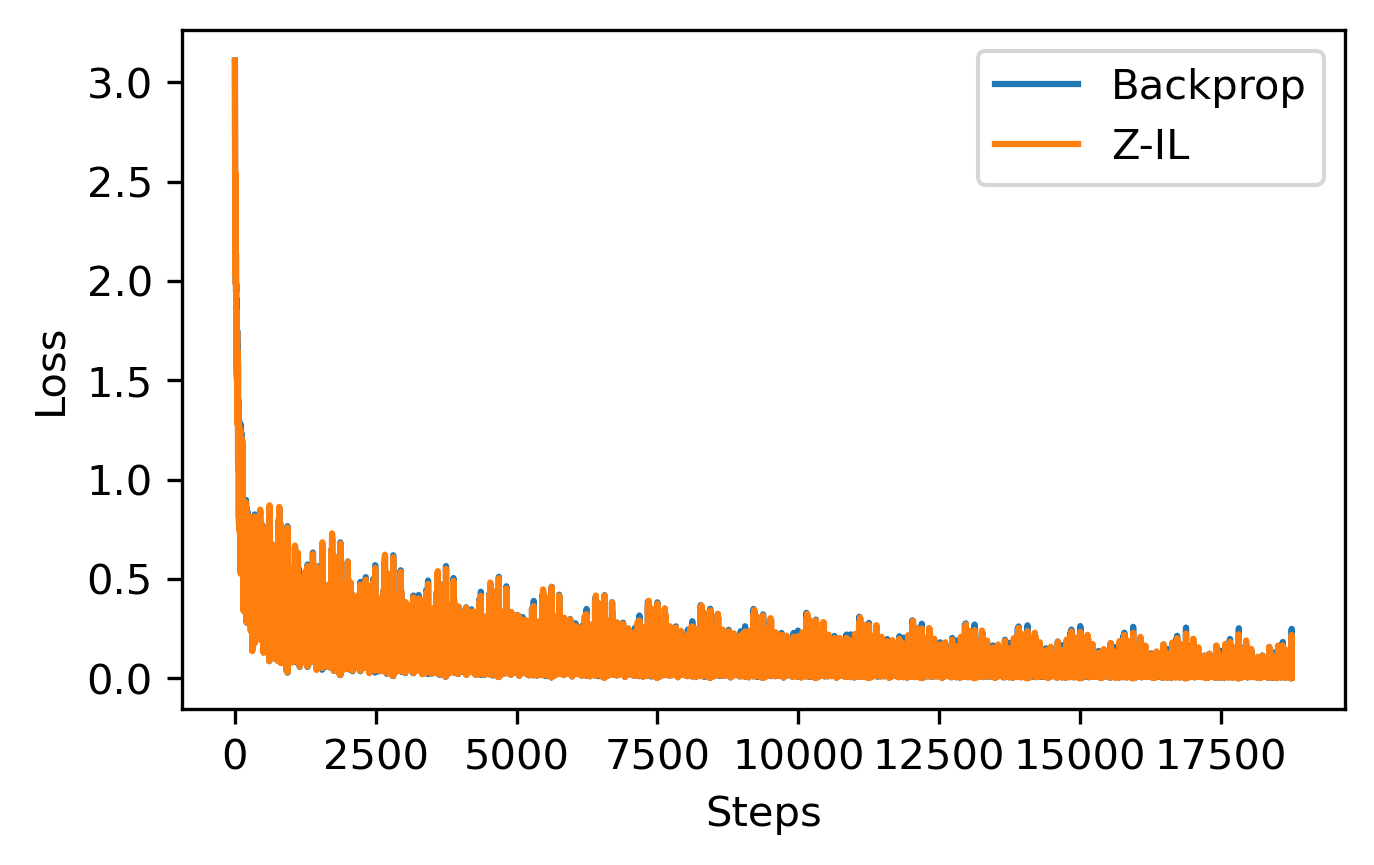

In [190]:
plt.figure(figsize=(5,3), dpi=300)
plt.plot(*zip(*backprop_loss_history))
plt.plot(*zip(*zil_loss_history))
plt.legend(["Backprop", "Z-IL"])
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.savefig("../report/graphics/Z-IL-backprop-loss.pdf", bbox_inches = "tight")
plt.show()